# Assignment 3: Contractive and Denoising Autoencoders

## Author: Fabrizio De Castelli

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow.keras as K
from sklearn.manifold import TSNE
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings


np.random.seed(42)
warnings.filterwarnings('ignore')

# comment all the following lines if run in local

"""
import sys

current_dir = %pwd
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

!git clone https://github.com/FabriDeCastelli/ISPR-23-24.git
os.chdir("ISPR-23-24/assignment3")
"""

# until here

# ------- GLOBAL VARIABLES -------
# MNIST dataset
MNIST_TRAINING_IMAGES_PATH = "dataset/train-images.idx3-ubyte"
MNIST_TRAINING_LABELS_PATH = "dataset/train-labels.idx1-ubyte"
MNIST_TEST_IMAGES_PATH = "dataset/t10k-images.idx3-ubyte"
MNIST_TEST_LABELS_PATH = "dataset/t10k-labels.idx1-ubyte"

# latent space dimension
LATENT_SPACE_DIMENSION = 128

#### Utility to load the MNIST dataset
Can specify the set to load: either 'training' or 'test'. This function provides the labels and the images.

In [24]:
def mnist(_set='training'):
    """
    Loads the MNIST dataset.

    :param _set: the set to load (either 'training' or 'test')
    
    :return: the images and the labels
    """

    if _set == 'training':
        images = MNIST_TRAINING_IMAGES_PATH
        labels = MNIST_TRAINING_LABELS_PATH
    elif _set == 'test':
        images = MNIST_TEST_IMAGES_PATH
        labels = MNIST_TEST_LABELS_PATH
    else:
        raise ValueError('Invalid set: provide either "training" or "test"')

    with open(images, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)

    with open(labels, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        _ = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return data.astype('float32') / 255., labels

def add_noise(data, noise=0.1):
    """
    Adds noise to the data.

    :param data: the data to add noise to
    :param noise: the noise to add to the data

    :return: the data with noise
    """
    noisy = data + noise * np.random.normal(loc=0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

def generate_noise(noise=0.1):
    """
    Generates noise to the data. The default noise is generated by a Normal distribution.

    :param noise: the noise to add to the data

    :return: the data with noise
    """
    noisy = noise * np.random.normal(loc=0, scale=1.0, size=(1, 784))
    return np.clip(noisy, 0., 1.)

def representative_images(data, targets, n=10):
    """
    Returns a representative image of the dataset.

    :param data: the images
    :param targets: the labels
    :param n: the number of representative images to return. Default is 10 (ten classes in MNIST)

    :return: n representative images, all of different classes
    """
    _, indices = np.unique(targets, return_index=True)
    return data[indices[:n]]

def plot_images(data, num_cols=10, title=""):
    """
    Plots the original and reconstructed images.

    :param data: the input data
    :param num_cols: the number of columns in the plot
    :param title: the title of the plot
    """
    num_images = len(data)
    num_rows = (num_images // num_cols) + (num_images % num_cols > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
    fig.text(0.5, 0.84, title, ha='center', fontsize=14)
    # In case we have only one row, the axs variable is not a list => convert it to a list
    if num_rows == 1:
        axs = [axs]
    
    for i in range(num_images):
        ax = axs[i // num_cols][i % num_cols]
        ax.set_title(f'Image {i}')
        ax.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    
    # Remove any empty subplots
    for i in range(num_images, num_cols * num_rows):
        fig.delaxes(axs[i // num_cols][i % num_cols])
        
    
    plt.tight_layout()
    plt.show()
    
def save_gif(directory, gif_name):
        """
        Creates and displays a gif of the latent space across the epochs.
        
        :param directory: the directory where to save the images
        :param gif_name: the name of the gif 
        """
        assert os.path.isdir(directory), "The path is not a directory"
        assert any([f.endswith('.png') for f in os.listdir(directory)]), \
            "The directory must contain only images"
        
        frames = []
        images = sorted(
            list(filter(lambda x: x.endswith('.png'), os.listdir(directory))),
            key=lambda x: int(x.split('_')[-1].split('.')[0])
        )
        
        for image in images:
            frames.append(Image.open(f'{directory}/{image}'))
            
        frames[0].save(
            f'{directory}/{gif_name}.gif', 
            format='GIF', 
            append_images=frames[1:], 
            save_all=True, 
            duration=1500, 
            loop=0
        )    

In [34]:
ff_encoder = K.models.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(LATENT_SPACE_DIMENSION * 4, activation='relu'),
    layers.Dense(LATENT_SPACE_DIMENSION * 2, activation='relu'),
    layers.Dense(LATENT_SPACE_DIMENSION, activation='relu'),
])

ff_decoder = K.models.Sequential([
    layers.Input(shape=(LATENT_SPACE_DIMENSION,)),
    layers.Dense(LATENT_SPACE_DIMENSION * 2, activation='relu'),
    layers.Dense(LATENT_SPACE_DIMENSION * 4, activation='relu'),
    layers.Dense(784, activation='sigmoid')
])
    
convolutions = K.models.Sequential([
    layers.Input(shape=(784,)),
    layers.Reshape((28, 28, 1)), # 28x28x1
    layers.Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same'),  # 14x14x32
    layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'),  # 7x7x64
    layers.Conv2D(128, kernel_size=3, strides=2, activation='relu', padding='valid'),  # 3x3x128
    layers.Flatten(), # 1152x1
    layers.Dense(10, activation='relu') # 10x1
], name="encoder")

print(convolutions.summary())

deconvolutions = K.models.Sequential([
    layers.Input(shape=(10,)), 
    layers.Dense(3*3*128, activation='relu'), # 1152x1
    layers.Reshape((3, 3, 128)), # 3x3x128
    layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='valid'),  # 7x7x64
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),  # 14x14x32
    layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same'),  # 28x28x1
    layers.Flatten() # 784x1
], name="decoder")

print(deconvolutions.summary())
    

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_14 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_22 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_14 (Flatten)        (None, 1152)              0         
                                                                 
 dense_62 (Dense)            (None, 10)                11530     
                                                                 
Total params: 104202 (407.04 KB)
Trainable params: 104202 (

## Deep Autoencoders

...


### Design Choices
- First choice.
- Second choice.

All the methods are implemented in the class Autoencoder. Brief descriptions of the methods are provided in the docstrings.

In [35]:
@tf.keras.utils.register_keras_serializable()
class Autoencoder(Model):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        

    def call(self, inputs, **kwargs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

    def plot_generations(self, steps=15, num_images=10, noise=0.1):
        
        assert num_images > 0
        fig, axes = plt.subplots(1, 10, figsize=(20, 2))
        for i in range(num_images):
            
            generation = self.generate(steps=steps, noise=noise)
            ax = axes[i]
            ax.imshow(generation.reshape(28, 28), cmap='gray')
            ax.axis('off')
            
        plt.show()
    
    def generate(self, steps=15, noise=0.1):
        """
        Generates images from noise.

        :param steps: number of steps to generate the images
        :param noise: the noise to add to the data
        """
        noise_image = generate_noise(noise=noise)
        for _ in range(steps):
         noise_image = self.predict(noise_image, verbose=0)  
        return noise_image
    
    
    def plot_manifold(self, n=30, figsize=10, steps=15, max_scale=1.0):
        """
        Plots a 2D manifold of digits in the latent space
        
        :param n: number of digits to plot in the manifold
        :param figsize: size of the figure
        :param steps: number of steps to generate the manifold
        :param max_scale: the maximum scale of the manifold

        """
        digit_size = 28
        scale = max_scale
        figure = np.zeros((digit_size * n, digit_size * n))
        
        grid_x = np.linspace(-scale, scale, n)
        grid_y = np.linspace(-scale, scale, n)[::-1]
        
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                
                generation = self.generate(steps=steps, noise=(xi + yi) / 2)
                    
                digit = generation[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.imshow(figure, cmap="Greys_r")
        plt.show()
        
    @classmethod
    def load(cls, path, encoder, decoder):
        """
        Loads the model from a file.

        :param path: the path to the file
        :param encoder: the encoder model
        :param decoder: the decoder model
        """
        m = tf.keras.models.load_model(path, compile=False)
        new_instance = cls(encoder, decoder)
        new_instance.set_weights(m.get_weights())
        return new_instance
    
    def get_config(self):
        return {
            "encoder": self.encoder,
            "decoder": self.decoder,
        }
    
    @classmethod
    def from_config(cls, config, **kwargs):
        return cls(**config)
    
class PlotCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, directory):
        super().__init__()
        os.makedirs(directory, exist_ok=True)
        self.directory = directory
        self.validation_data, self.validation_targets = validation_data
        
    def on_train_begin(self, logs=None):
        for f in os.listdir(self.directory):
            os.remove(f'{self.directory}/{f}')
      
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0:
            return
        self.plot_latent_space(epoch)
        
    def plot_latent_space(self, epoch):
        
        latent = self.model.encoder(self.validation_data)
        latent = TSNE(n_components=2).fit_transform(latent)
        # plot the latent space
        plt.figure(figsize=(10, 10))
        sns.scatterplot(x=latent[:, 0], y=latent[:, 1], hue=self.validation_targets, palette='tab10')
        plt.savefig(f'{self.directory}/epoch_{epoch + 1}.png')
        plt.close()
        
    def on_train_end(self, logs=None):
        self.plot_latent_space(epoch=25)
        save_gif(self.directory, 'latent_space')
        

In [36]:
# load the MNIST dataset
training_images, training_labels = mnist('training')
test_images, test_labels = mnist('test')

# add noise to the data
noise_factor = 0.7
training_noisy_images = add_noise(training_images, noise_factor)
test_noisy_images = add_noise(test_images, noise_factor)

# common training details
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


## Denoising Autoencoder (Feedforward)

In [6]:
ff_denoising_autoencoder = Autoencoder(ff_encoder, ff_decoder)
ff_denoising_autoencoder.compile(optimizer="adam", loss="mean_squared_error")

plot_checkpoint = PlotCheckpoint((test_noisy_images, test_labels), "plots/feed_forward/denoising_autoencoder")

_ = ff_denoising_autoencoder.fit(
    training_noisy_images, 
    training_images, 
    epochs=25, 
    batch_size=100,
    shuffle=True,
    callbacks=[early_stopping, plot_checkpoint],
    validation_data=(test_noisy_images, test_images),
    verbose=2
)

Epoch 1/25
600/600 - 21s - loss: 0.0451 - val_loss: 0.0327 - 21s/epoch - 35ms/step
Epoch 2/25
600/600 - 3s - loss: 0.0296 - val_loss: 0.0273 - 3s/epoch - 5ms/step
Epoch 3/25
600/600 - 3s - loss: 0.0260 - val_loss: 0.0249 - 3s/epoch - 5ms/step
Epoch 4/25
600/600 - 3s - loss: 0.0238 - val_loss: 0.0243 - 3s/epoch - 5ms/step
Epoch 5/25
600/600 - 3s - loss: 0.0224 - val_loss: 0.0233 - 3s/epoch - 5ms/step
Epoch 6/25
600/600 - 19s - loss: 0.0213 - val_loss: 0.0224 - 19s/epoch - 31ms/step
Epoch 7/25
600/600 - 3s - loss: 0.0204 - val_loss: 0.0220 - 3s/epoch - 5ms/step
Epoch 8/25
600/600 - 3s - loss: 0.0197 - val_loss: 0.0221 - 3s/epoch - 5ms/step
Epoch 9/25
600/600 - 3s - loss: 0.0190 - val_loss: 0.0220 - 3s/epoch - 5ms/step
Epoch 10/25
600/600 - 3s - loss: 0.0185 - val_loss: 0.0216 - 3s/epoch - 5ms/step
Epoch 11/25
600/600 - 19s - loss: 0.0180 - val_loss: 0.0216 - 19s/epoch - 32ms/step
Epoch 12/25
600/600 - 3s - loss: 0.0176 - val_loss: 0.0217 - 3s/epoch - 5ms/step
Epoch 13/25
600/600 - 3s - l

In [ ]:
ff_denoising_autoencoder.save("models/feed_forward/denoising_autoencoder")

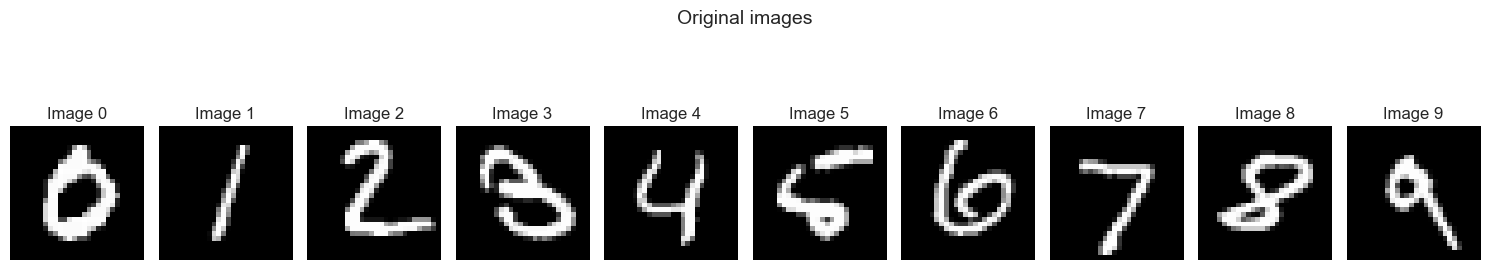

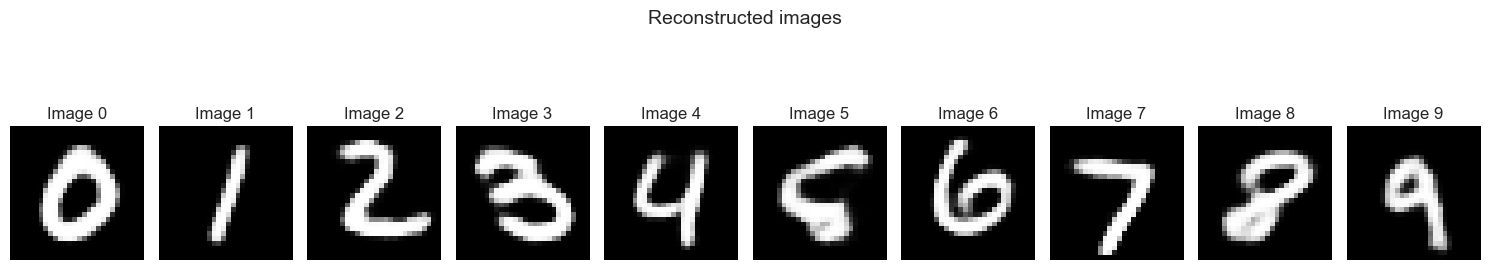

In [8]:
ff_denoising_autoencoder = Autoencoder.load("models/feed_forward/denoising_autoencoder", ff_encoder, ff_decoder)
zero_to_ten = representative_images(test_images, test_labels)
zero_to_ten_reconstruction = ff_denoising_autoencoder.predict(zero_to_ten, verbose=0)
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

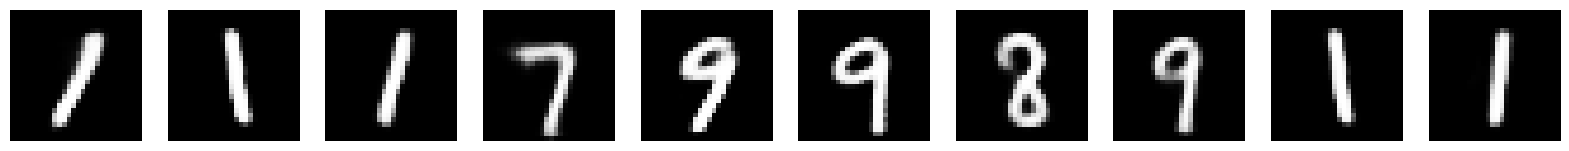

In [9]:
ff_denoising_autoencoder.plot_generations(noise=noise_factor, steps=4)

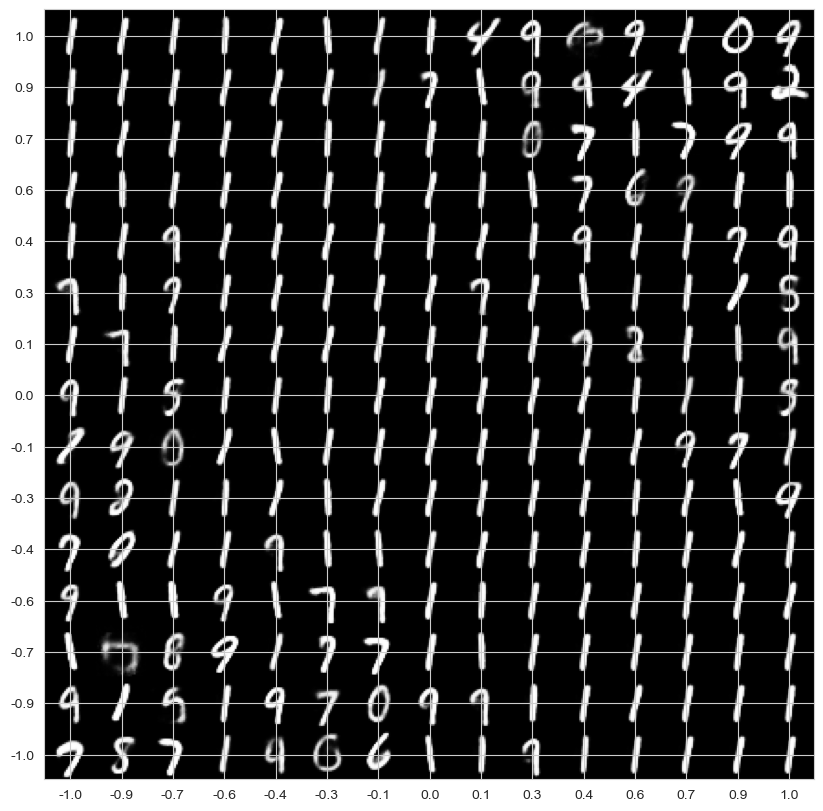

In [10]:
ff_denoising_autoencoder.plot_manifold(n=15, steps=4, max_scale=1)

## Denoising Autoencoder (Convolutional)

In [37]:
conv_denoising_autoencoder = Autoencoder(convolutions, deconvolutions)

conv_denoising_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

plot_checkpoint = PlotCheckpoint((test_noisy_images, test_labels), "plots/convolutional/denoising_autoencoder")

_ = conv_denoising_autoencoder.fit(
    training_noisy_images, 
    training_images,
    epochs=25, 
    batch_size=100,
    shuffle=True,
    callbacks=[early_stopping, plot_checkpoint],
    validation_data=(test_noisy_images, test_images),
    verbose=2
)


Epoch 1/25
600/600 - 27s - loss: 0.0828 - val_loss: 0.0470 - 27s/epoch - 45ms/step
Epoch 2/25
600/600 - 8s - loss: 0.0381 - val_loss: 0.0342 - 8s/epoch - 14ms/step
Epoch 3/25
600/600 - 9s - loss: 0.0331 - val_loss: 0.0316 - 9s/epoch - 14ms/step
Epoch 4/25
600/600 - 9s - loss: 0.0308 - val_loss: 0.0291 - 9s/epoch - 14ms/step
Epoch 5/25
600/600 - 9s - loss: 0.0287 - val_loss: 0.0278 - 9s/epoch - 14ms/step
Epoch 6/25
600/600 - 27s - loss: 0.0276 - val_loss: 0.0271 - 27s/epoch - 45ms/step
Epoch 7/25
600/600 - 8s - loss: 0.0269 - val_loss: 0.0266 - 8s/epoch - 13ms/step
Epoch 8/25
600/600 - 8s - loss: 0.0263 - val_loss: 0.0262 - 8s/epoch - 13ms/step
Epoch 9/25
600/600 - 8s - loss: 0.0259 - val_loss: 0.0258 - 8s/epoch - 13ms/step
Epoch 10/25
600/600 - 8s - loss: 0.0255 - val_loss: 0.0256 - 8s/epoch - 13ms/step
Epoch 11/25
600/600 - 27s - loss: 0.0252 - val_loss: 0.0255 - 27s/epoch - 44ms/step
Epoch 12/25
600/600 - 8s - loss: 0.0249 - val_loss: 0.0254 - 8s/epoch - 14ms/step
Epoch 13/25
600/600

In [ ]:
conv_denoising_autoencoder.save("models/convolutional/denoising_autoencoder")

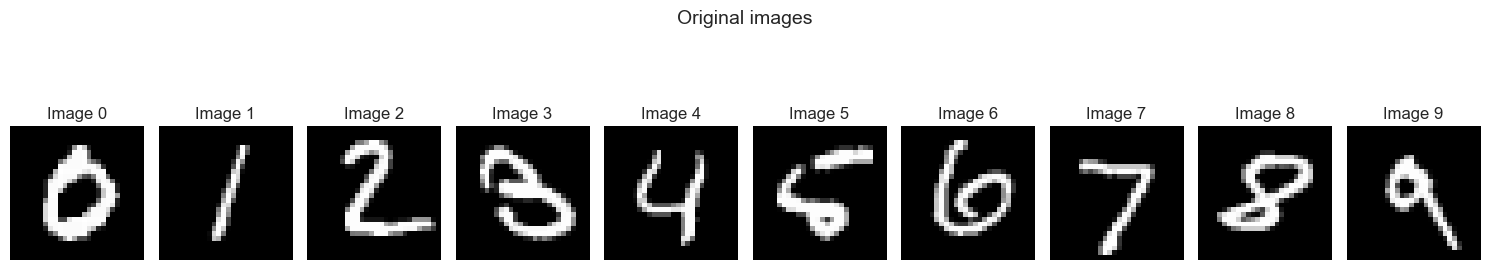

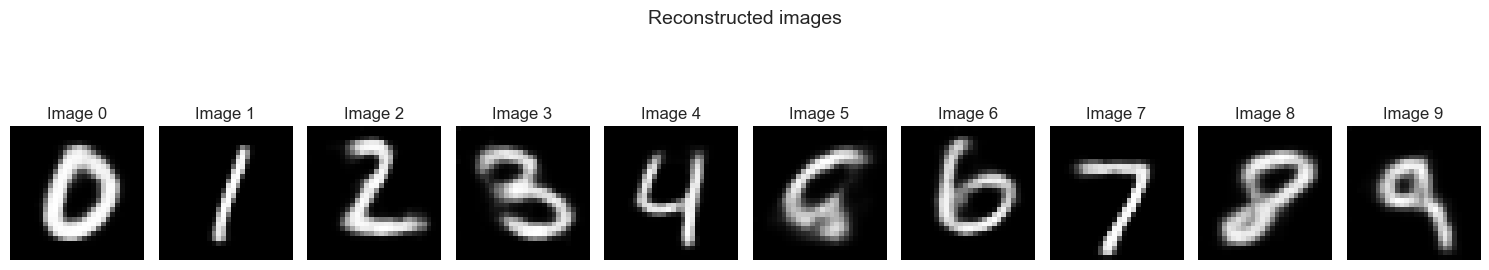

In [39]:
# Plot the original and reconstructed images
conv_denoising_autoencoder = Autoencoder.load("models/convolutional/denoising_autoencoder", convolutions, deconvolutions)
zero_to_ten = representative_images(test_images, test_labels)
zero_to_ten_reconstruction = conv_denoising_autoencoder.predict(zero_to_ten, verbose=0)
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

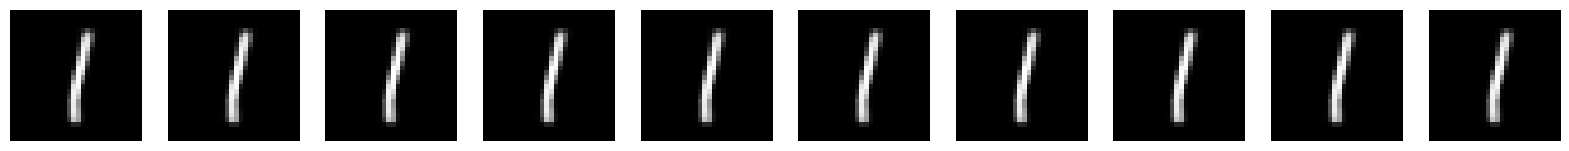

In [41]:
conv_denoising_autoencoder.plot_generations(noise=noise_factor)

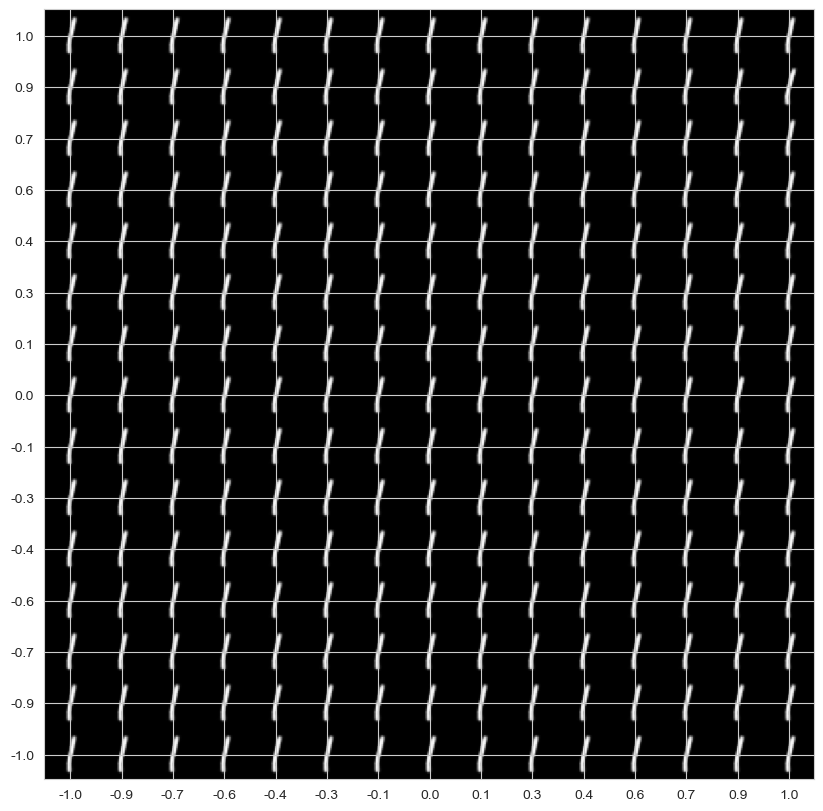

In [42]:
conv_denoising_autoencoder.plot_manifold(n=15, max_scale=1)

## Contractive Autoencoder

In [43]:
def contractive_loss(encoder, lam):
    
    @tf.function
    def loss(reconstruction, original):
        mse = losses.MeanSquaredError()(reconstruction, original)
        with tf.GradientTape() as tape:
            tape.watch(original)
            z = encoder(original)
        encoding_gradients = tape.gradient(z, original)
        frobenius_norm = tf.reduce_sum(tf.square(encoding_gradients), axis=1)
        return mse + lam * frobenius_norm
    
    return loss


ff_contractive_autoencoder = Autoencoder(encoder=ff_encoder, decoder=ff_decoder)

contractive_l = contractive_loss(ff_contractive_autoencoder.encoder, 1e-4)

ff_contractive_autoencoder.compile(optimizer='adam', loss=contractive_l)

plot_checkpoint = PlotCheckpoint((test_noisy_images, test_labels), "plots/feed_forward/contractive_autoencoder")

ff_contractive_autoencoder.fit(
    training_noisy_images, 
    training_images, 
    batch_size=100,
    epochs=25, 
    shuffle=True,
    callbacks=[early_stopping, plot_checkpoint],
    validation_data=(test_noisy_images, test_images),
    verbose=2
)


Epoch 1/25
600/600 - 22s - loss: 0.0482 - val_loss: 0.0338 - 22s/epoch - 37ms/step
Epoch 2/25
600/600 - 5s - loss: 0.0313 - val_loss: 0.0291 - 5s/epoch - 8ms/step
Epoch 3/25
600/600 - 5s - loss: 0.0276 - val_loss: 0.0261 - 5s/epoch - 8ms/step
Epoch 4/25
600/600 - 5s - loss: 0.0253 - val_loss: 0.0252 - 5s/epoch - 8ms/step
Epoch 5/25
600/600 - 5s - loss: 0.0238 - val_loss: 0.0240 - 5s/epoch - 8ms/step
Epoch 6/25
600/600 - 22s - loss: 0.0226 - val_loss: 0.0233 - 22s/epoch - 36ms/step
Epoch 7/25
600/600 - 5s - loss: 0.0217 - val_loss: 0.0228 - 5s/epoch - 8ms/step
Epoch 8/25
600/600 - 5s - loss: 0.0209 - val_loss: 0.0229 - 5s/epoch - 8ms/step
Epoch 9/25
600/600 - 5s - loss: 0.0204 - val_loss: 0.0219 - 5s/epoch - 9ms/step
Epoch 10/25
600/600 - 5s - loss: 0.0198 - val_loss: 0.0220 - 5s/epoch - 8ms/step
Epoch 11/25
600/600 - 23s - loss: 0.0194 - val_loss: 0.0224 - 23s/epoch - 38ms/step
Epoch 12/25
600/600 - 5s - loss: 0.0190 - val_loss: 0.0220 - 5s/epoch - 8ms/step


In [ ]:
ff_contractive_autoencoder.save("models/feed_forward/contractive_autoencoder")

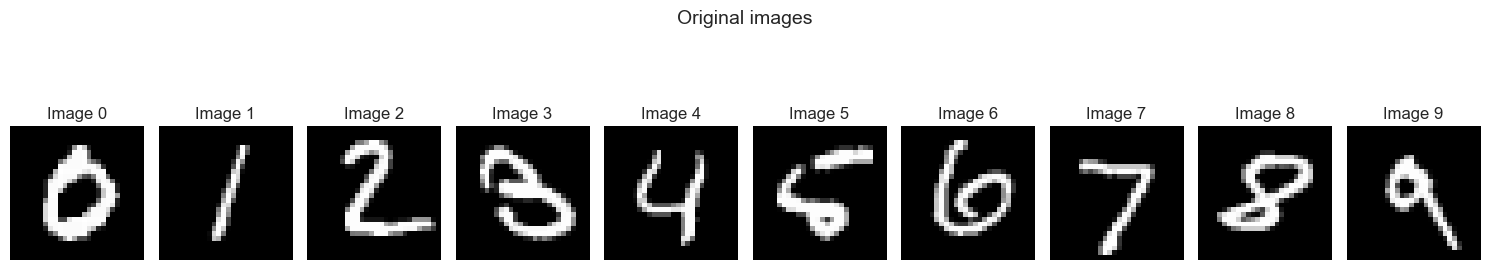

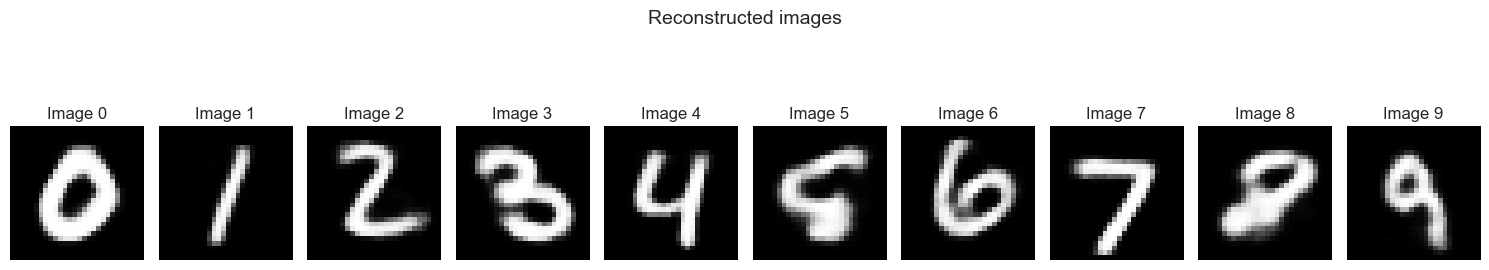

In [45]:
# Plot the original and reconstructed images
ff_contractive_autoencoder = Autoencoder.load("models/feed_forward/contractive_autoencoder", ff_encoder, ff_decoder)
zero_to_ten = representative_images(test_images, test_labels)
zero_to_ten_reconstruction = ff_contractive_autoencoder.predict(zero_to_ten, verbose=0)
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

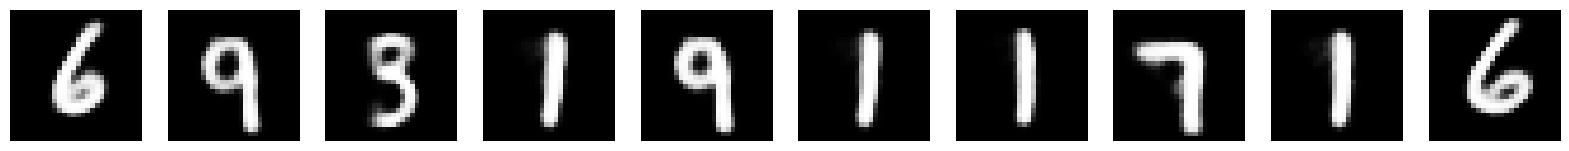

In [52]:
ff_contractive_autoencoder.plot_generations(noise=noise_factor, steps=6)

In [ ]:
ff_contractive_autoencoder.plot_manifold(n=15, max_scale=1, steps=6)

## Convolutional Contractive Autoencoder

In [54]:
conv_contractive_autoencoder = Autoencoder(encoder=convolutions, decoder=deconvolutions)

conv_contractive_autoencoder.compile(optimizer='adam', loss=contractive_l)

plot_checkpoint = PlotCheckpoint((test_noisy_images, test_labels), "plots/convolutional/contractive_autoencoder")

conv_contractive_autoencoder.fit(
    training_noisy_images, 
    training_images, 
    batch_size=100,
    epochs=25, 
    shuffle=True,
    callbacks=[early_stopping, plot_checkpoint],
    validation_data=(test_noisy_images, test_images),
    verbose=1
)

Epoch 1/25
600/600 [==============================] - 29s 49ms/step - loss: 0.0230 - val_loss: 0.0251
Epoch 2/25
600/600 [==============================] - 10s 16ms/step - loss: 0.0229 - val_loss: 0.0250
Epoch 3/25
600/600 [==============================] - 10s 16ms/step - loss: 0.0228 - val_loss: 0.0252
Epoch 4/25
600/600 [==============================] - 10s 16ms/step - loss: 0.0227 - val_loss: 0.0252
Epoch 5/25
600/600 [==============================] - 10s 17ms/step - loss: 0.0226 - val_loss: 0.0251


In [55]:
conv_contractive_autoencoder.save("models/convolutional/contractive_autoencoder")

KeyError: 'Failed to add concrete function \'b\'__inference_loss_440159\'\' to object-based SavedModel as it captures tensor <tf.Tensor: shape=(), dtype=resource, value=<ResourceHandle(name="Resource-2294-at-0x600002e3abc0", device="/job:localhost/replica:0/task:0/device:CPU:0", container="Anonymous", type="tensorflow::Var", dtype and shapes : "[ DType enum: 1, Shape: [784,512] ]")>> which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable).'

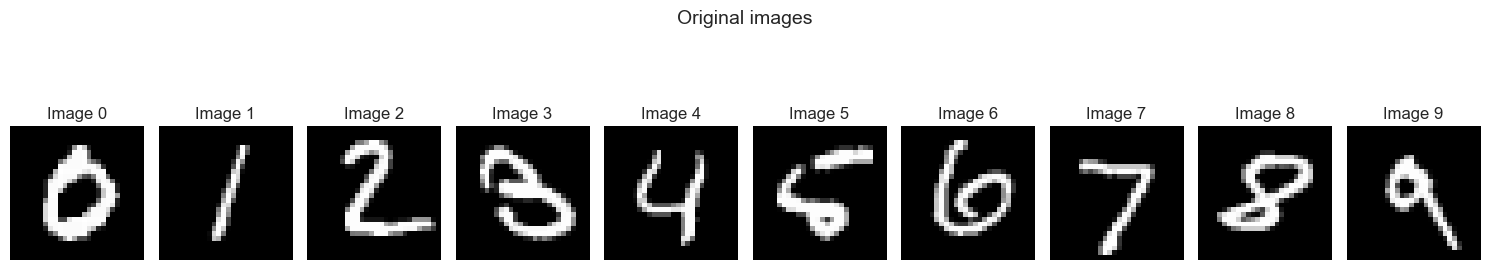

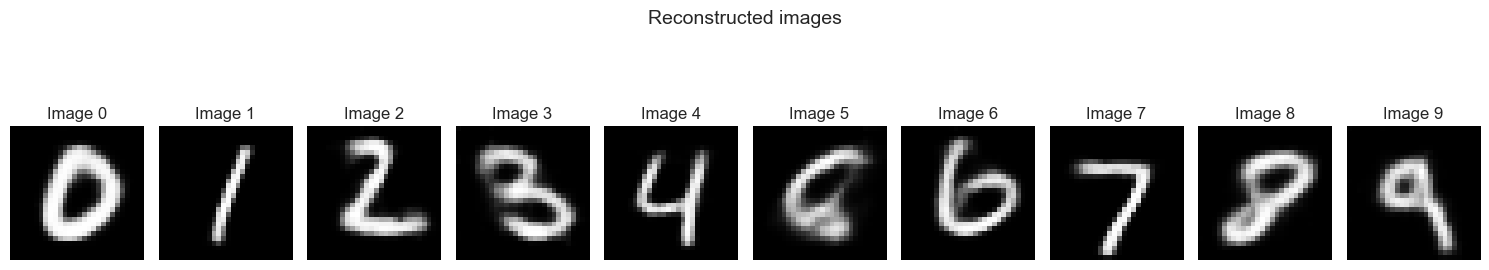

In [56]:
# Plot the original and reconstructed images
# conv_contractive_autoencoder = Autoencoder.load("models/convolutional/contractive_autoencoder", convolutions, deconvolutions)
zero_to_ten = representative_images(test_images, test_labels)
zero_to_ten_reconstruction = conv_contractive_autoencoder.predict(zero_to_ten, verbose=0)
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

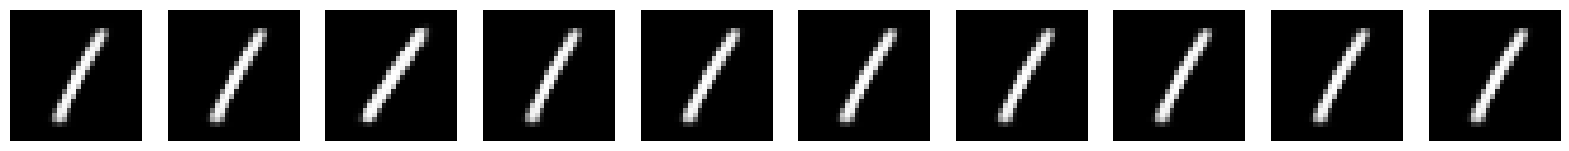

In [62]:
conv_contractive_autoencoder.plot_generations(noise=noise_factor)

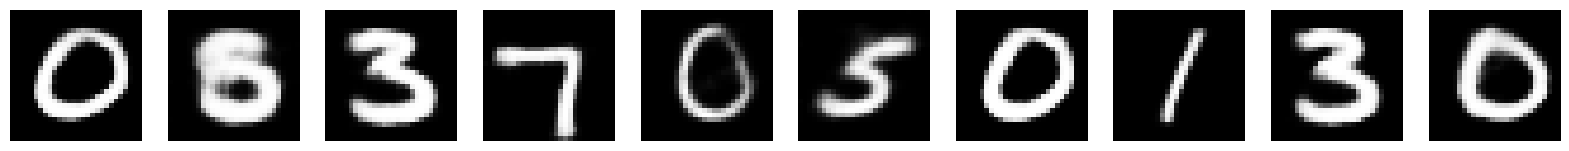

In [69]:
conv_contractive_autoencoder.plot_generations(noise=7)

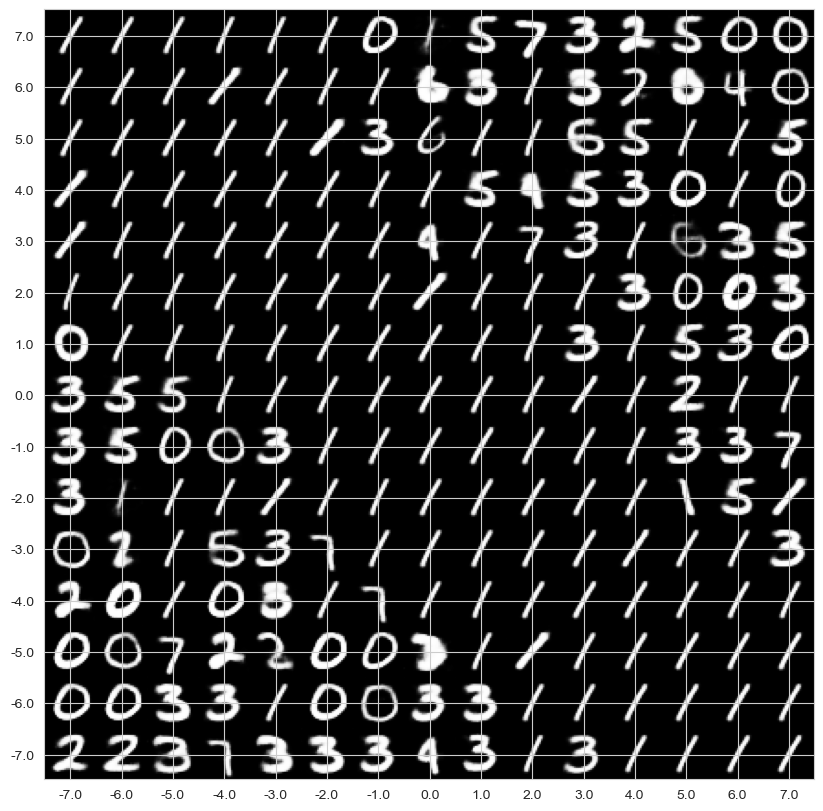

In [71]:
conv_contractive_autoencoder.plot_manifold(n=15, max_scale=7)

## Conclusions

In this assignment, we implemented ...